# Data Types, Graphical Marks, and Visual Encoding Channels

A visualization represents data using a collection of _graphical marks_ (bars, lines, points, etc.). The attributes of a mark &mdash; such as its position, shape, size, or color &mdash; serve as _channels_ through which we can encode underlying data values.

With a basic framework of _data types_, _marks_, and _encoding channels_, we can concisely create a wide variety of visualizations. In this notebook, we explore each of these elements and show how to use them to create custom statistical graphics.

_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum)._

In [1]:
import pandas as pd
import altair as alt

## Global Development Data


We will be visualizing global health and population data for a number of countries, over the time period of 1955 to 2005. The data was collected by the [Gapminder Foundation](https://www.gapminder.org/) and shared in [Hans Rosling's popular TED talk](https://www.youtube.com/watch?v=hVimVzgtD6w). If you haven't seen the talk, we encourage you to watch it first!

Let's first load the dataset from the [vega-datasets](https://github.com/vega/vega-datasets) collection into a Pandas data frame.

In [2]:
from vega_datasets import data as vega_data
data = pd.read_json(vega_data.gapminder.url)

How big is the data?

In [3]:
data.shape

(693, 6)

693 rows and 6 columns! Let's take a peek at the data content:

In [4]:
data.head(5)

,year,country,cluster,pop,life_expect,fertility
0,1955,Afghanistan,0,8891209,30.332,7.7
1,1960,Afghanistan,0,9829450,31.997,7.7
2,1965,Afghanistan,0,10997885,34.020,7.7
3,1970,Afghanistan,0,12430623,36.088,7.7
4,1975,Afghanistan,0,14132019,38.438,7.7


For each `country` and `year` (in 5-year intervals), we have measures of fertility in terms of the number of children per woman (`fertility`), life expectancy in years (`life_expect`), and total population (`pop`).

We also see a `cluster` field with an integer code. What might this represent? We'll try and solve this mystery as we visualize the data!

Let's also create a smaller data frame, filtered down to values for the year 2000 only:

In [5]:
data2000 = data.loc[data['year'] == 2000]

In [6]:
data2000.head(5)

,year,country,cluster,pop,life_expect,fertility
9,2000,Afghanistan,0,23898198,42.129,7.4792
20,2000,Argentina,3,37497728,74.340,2.3500
31,2000,Aruba,3,69539,73.451,2.1240
42,2000,Australia,4,19164620,80.370,1.7560
53,2000,Austria,1,8113413,78.980,1.3820


## Data Types


The first ingredient in effective visualization is the input data. Data values can represent different forms of measurement. What kinds of comparisons do those measurements support? And what kinds of visual encodings then support those comparisons?

We will start by looking at the basic data types that Altair uses to inform visual encoding choices. These data types determine the kinds of comparisons we can make, and thereby guide our visualization design decisions.

### Nominal (N)

*Nominal* data (also called *categorical* data) consist of category names. 

With nominal data we can compare the equality of values: *is value A the same or different than value B? (A = B)*, supporting statements like “A is equal to B” or “A is not equal to B”.
In the dataset above, the `country` field is nominal.

When visualizing nominal data we should readily be able to see if values are the same or different: position, color hue (blue, red, green, *etc.*), and shape can help. However, using a size channel to encode nominal data might mislead us, suggesting rank-order or magnitude differences among values that do not exist!

### Ordinal (O)

*Ordinal* data consist of values that have a specific ordering.

With ordinal data we can compare the rank-ordering of values: *does value A come before or after value B? (A < B)*, supporting statements like “A is less than B” or “A is greater than B”.
In the dataset above, we can treat the `year` field as ordinal.

When visualizing ordinal data, we should perceive a sense of rank-order. Position, size, or color value (brightness) might be appropriate, where as color hue (which is not perceptually ordered) would be less appropriate.

### Quantitative (Q)

With *quantitative* data we can measure numerical differences among values. There are multiple sub-types of quantitative data:

For *interval* data we can measure the distance (interval) between points: *what is the distance to value A from value B? (A - B)*, supporting statements such as “A is 12 units away from B”.

For *ratio* data the zero-point is meaningful and so we can also measure proportions or scale factors: *value A is what proportion of value B? (A / B)*, supporting statements such as “A is 10% of B” or “B is 7 times larger than A”.

In the dataset above, `year` is a quantitative interval field (the value of year "zero" is subjective), whereas `fertility` and `life_expect` are quantitative ratio fields (zero is meaningful for calculating proportions).
Vega-Lite represents quantitative data, but does not make a distinction between interval and ratio types.

Quantitative values can be visualized using position, size, or color value, among other channels. An axis with a zero baseline is essential for proportional comparisons of ratio values, but can be safely omitted for interval comparisons.

### Temporal (T)

*Temporal* values measure time points or intervals. This type is a special case of quantitative values (timestamps) with rich semantics and conventions (i.e., the [Gregorian calendar](https://en.wikipedia.org/wiki/Gregorian_calendar)). The temporal type in Vega-Lite supports reasoning about time units (year, month, day, hour, etc.), and provides methods for requesting specific time intervals.

Example temporal values include date strings such as `“2019-01-04”` and `“Jan 04 2019”`, as well as standardized date-times such as the [ISO date-time format](https://en.wikipedia.org/wiki/ISO_8601): `“2019-01-04T17:50:35.643Z”`.

There are no temporal values in our global development dataset above, as the `year` field is simply encoded as an integer. For more details about using temporal data in Altair, see the [Times and Dates documentation](https://altair-viz.github.io/user_guide/times_and_dates.html).

### Summary

These data types are not mutually exclusive, but rather form a hierarchy: ordinal data support nominal (equality) comparisons, while quantitative data support ordinal (rank-order) comparisons.

Moreover, these data types do _not_ provide a fixed categorization. Just because a data field is represented using a number doesn't mean we have to treat it as a quantitative type! For example, we might interpret a set of ages (10 years old, 20 years old, etc) as nominal (underage or overage), ordinal (grouped by year), or quantitative (calculate average age).

Now let's examine how to visually encode these data types!


## Encoding Channels

At the heart of Altair is the use of *encodings* that bind data fields (with a given data type) to available encoding *channels* of a chosen *mark* type. In this notebook we'll examine the following encoding channels:

- `x`: Horizontal (x-axis) position of the mark.
- `y`: Vertical (y-axis) position of the mark.
- `size`: Size of the mark. May correspond to area or length, depending on the mark type.
- `color`: Mark color, specified as a [legal CSS color](https://developer.mozilla.org/en-US/docs/Web/CSS/color_value).
- `opacity`: Mark opacity, ranging from 0 (fully transparent) to 1 (fully opaque).
- `shape`: Plotting symbol shape for `point` marks.
- `tooltip`: Tooltip text to display upon mouse hover over the mark.
- `order`: Mark ordering, determines line/area point order and drawing order.
- `column`: Facet the data into horizontally-aligned subplots.
- `row`: Facet the data into vertically-aligned subplots.

For a complete list of available channels, see the [Altair encoding documentation](https://altair-viz.github.io/user_guide/encoding.html).

### X

The `x` encoding channel sets a mark's horizontal position (x-coordinate). In addition, default choices of axis and title are made automatically. In the chart below, the choice of a quantitative data type results in a continuous linear axis scale:

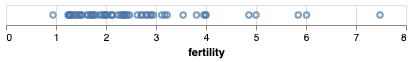

In [7]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q')
)

### Y

The `y` encoding channel sets a mark's vertical position (y-coordinate). Here we've added the `cluster` field using an ordinal (`O`) data type. The result is a discrete axis that includes a sized band, with a default step size, for each unique value:

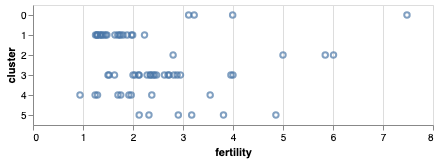

In [8]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:O')
)

_What happens to the chart above if you swap the `O` and `Q` field types?_

If we instead add the `life_expect` field as a quantitative (`Q`) variable, the result is a scatter plot with linear scales for both axes:

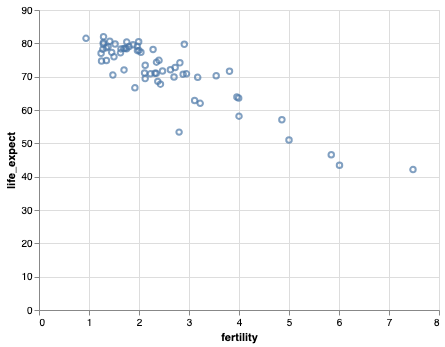

In [9]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q')
)

By default, axes for linear quantitative scales include zero to ensure a proper baseline for comparing ratio-valued data. In some cases, however, a zero baseline may be meaningless or you may want to focus on interval comparisons. To disable automatic inclusion of zero, configure the scale mapping using the encoding `scale` attribute:

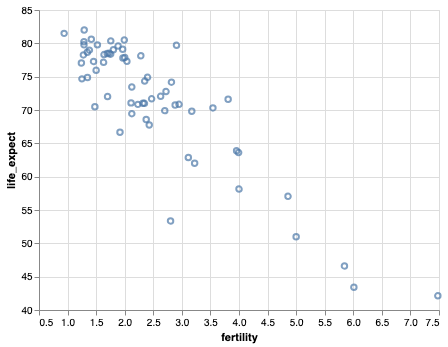

In [10]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q', scale=alt.Scale(zero=False)),
    alt.Y('life_expect:Q', scale=alt.Scale(zero=False))
)

Now the axis scales no longer include zero by default. Some padding still remains, as the axis domain end points are automatically snapped to _nice_ numbers like multiples of 5 or 10.

_What happens if you also add `nice=False` to the scale attribute above?_

### Size

The `size` encoding channel sets a mark's size or extent. The meaning of the channel can vary based on the mark type. For `point` marks, the `size` channel maps to the pixel area of the plotting symbol, such that the diameter of the point matches the square root of the size value.

Let's augment our scatter plot by encoding population (`pop`) on the `size` channel. As a result, the chart now also includes a legend for interpreting the size values.

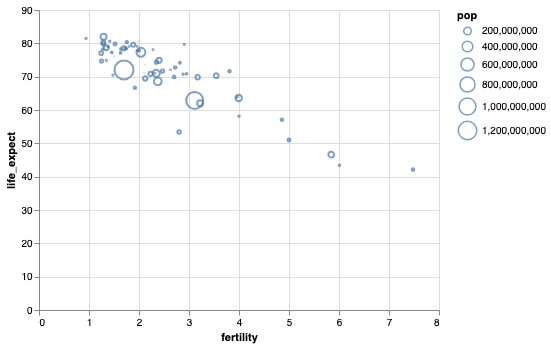

In [11]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q')
)

In some cases we might be unsatisfied with the default size range. To provide a customized span of sizes, set the `range` parameter of the `scale` attribute to an array indicating the smallest and largest sizes. Here we update the size encoding to range from 0 pixels (for zero values) to 1,000 pixels (for the maximum value in the scale domain):

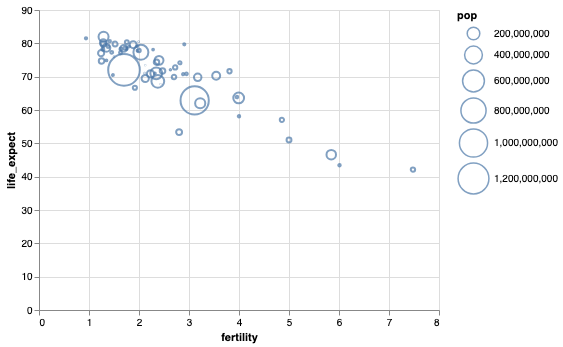

In [12]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000]))
)

### Color and Opacity

The `color` encoding channel sets a mark's color. The style of color encoding is highly dependent on the data type: nominal data will default to a multi-hued qualitative color scheme, whereas ordinal and quantitative data will use perceptually ordered color gradients.

Here, we encode the `cluster` field using the `color` channel and a nominal (`N`) data type, resulting in a distinct hue for each cluster value. Can you start to guess what the `cluster` field might indicate?


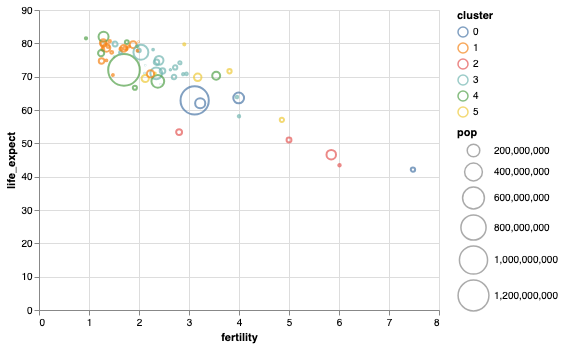

In [13]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N')
)

If we prefer filled shapes, we can can pass a `filled=True` parameter to the `mark_point` method:

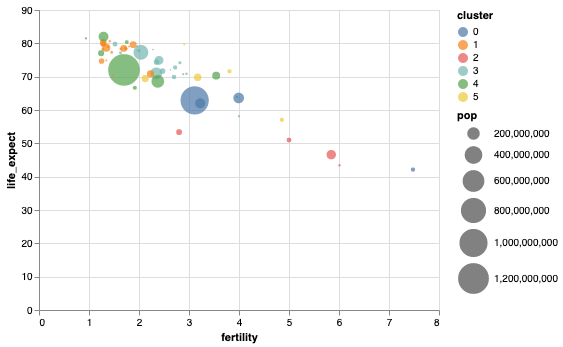

In [14]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N')
)

By default, Altair uses a bit of transparency to help combat over-plotting. We are free to further adjust the opacity, either by passing a default value to the `mark_*` method, or using a dedicated encoding channel.

Here we demonstrate how to provide a constant value to an encoding channel instead of binding a data field:

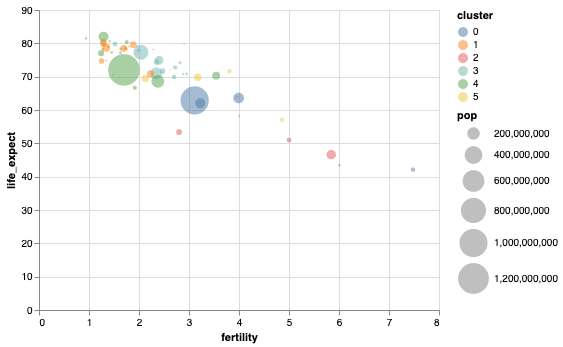

In [15]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5)
)

### Shape

The `shape` encoding channel sets the geometric shape used by `point` marks. Unlike the other channels we have seen so far, the `shape` channel can not be used by other mark types. The shape encoding channel should only be used with nominal data, as perceptual rank-order and magnitude comparisons are not supported.

Let's encode the `cluster` field using `shape` as well as `color`. Using multiple channels for the same underlying data field is known as a *redundant encoding*. The resulting chart combines both color and shape information into a single symbol legend:

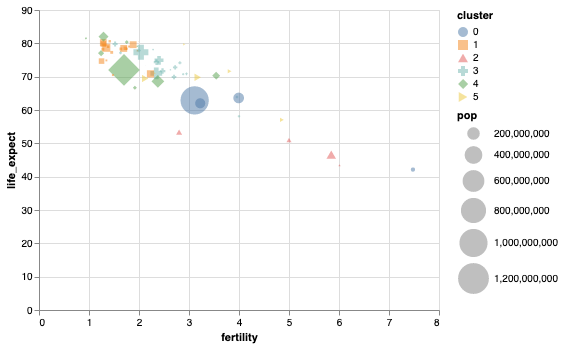

In [16]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5),
    alt.Shape('cluster:N')
)

### Tooltips & Ordering

By this point, you might feel a bit frustrated: we've built up a chart, but we still don't know what countries the visualized points correspond to! Let's add interactive tooltips to enable exploration.

The `tooltip` encoding channel determines tooltip text to show when a user moves the mouse cursor over a mark. Let's add a tooltip encoding for the `country` field, then investigate which countries are being represented.


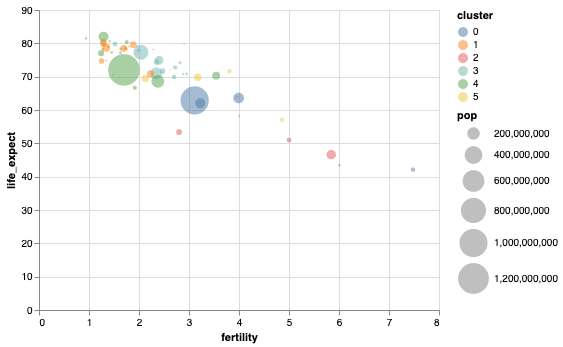

In [17]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5),
    alt.Tooltip('country')
)

As you mouse around you may notice that you can not select some of the points. For example, the largest dark blue circle corresponds to India, which is drawn on top of a country with a smaller population, preventing the mouse from hovering over that country. To fix this problem, we can use the `order` encoding channel.

The `order` encoding channel determines the order of data points, affecting both the order in which they are drawn and, for `line` and `area` marks, the order in which they are connected to one another.

Let's order the values in descending rank order by the population (`pop`), ensuring that smaller circles are drawn later than larger circles:

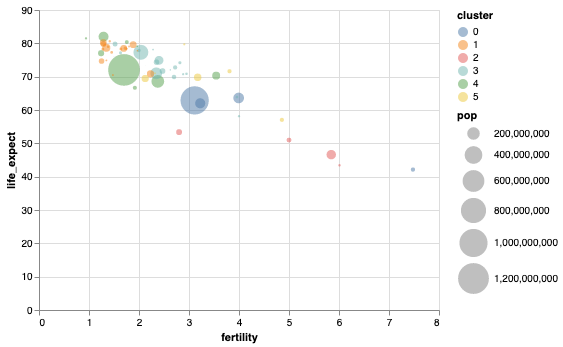

In [18]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending')
)

Now we can identify the smaller country being obscured by India: it's Bangladesh!

We can also now figure out what the `cluster` field represents. Mouse over the various colored points to formulate your own explanation.

At this point we've added tooltips that show only a single property of the underlying data record. To show multiple values, we can provide the `tooltip` channel an array of encodings, one for each field we want to include:

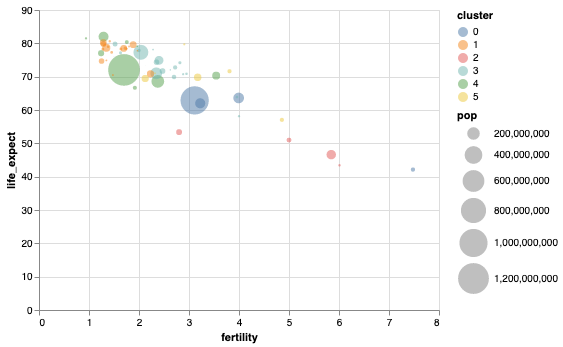

In [19]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5),
    alt.Order('pop:Q', sort='descending'),
    tooltip = [
        alt.Tooltip('country:N'),
        alt.Tooltip('fertility:Q'),
        alt.Tooltip('life_expect:Q')
    ]   
)

Now we can see multiple data fields upon mouse over!

### Column and Row Facets

Spatial position is one of the most powerful and flexible channels for visual encoding, but what can we do if we already have assigned fields to the `x` and `y` channels? One valuable technique is to create a *trellis plot*, consisting of sub-plots that show a subset of the data. A trellis plot is one example of the more general technique of presenting data using [small multiples](https://en.wikipedia.org/wiki/Small_multiple) of views.

The `column` and `row` encoding channels generate either a horizontal (columns) or vertical (rows) set of sub-plots, in which the data is partitioned according to the provided data field.

Here is a trellis plot that divides the data into one column per \`cluster\` value:

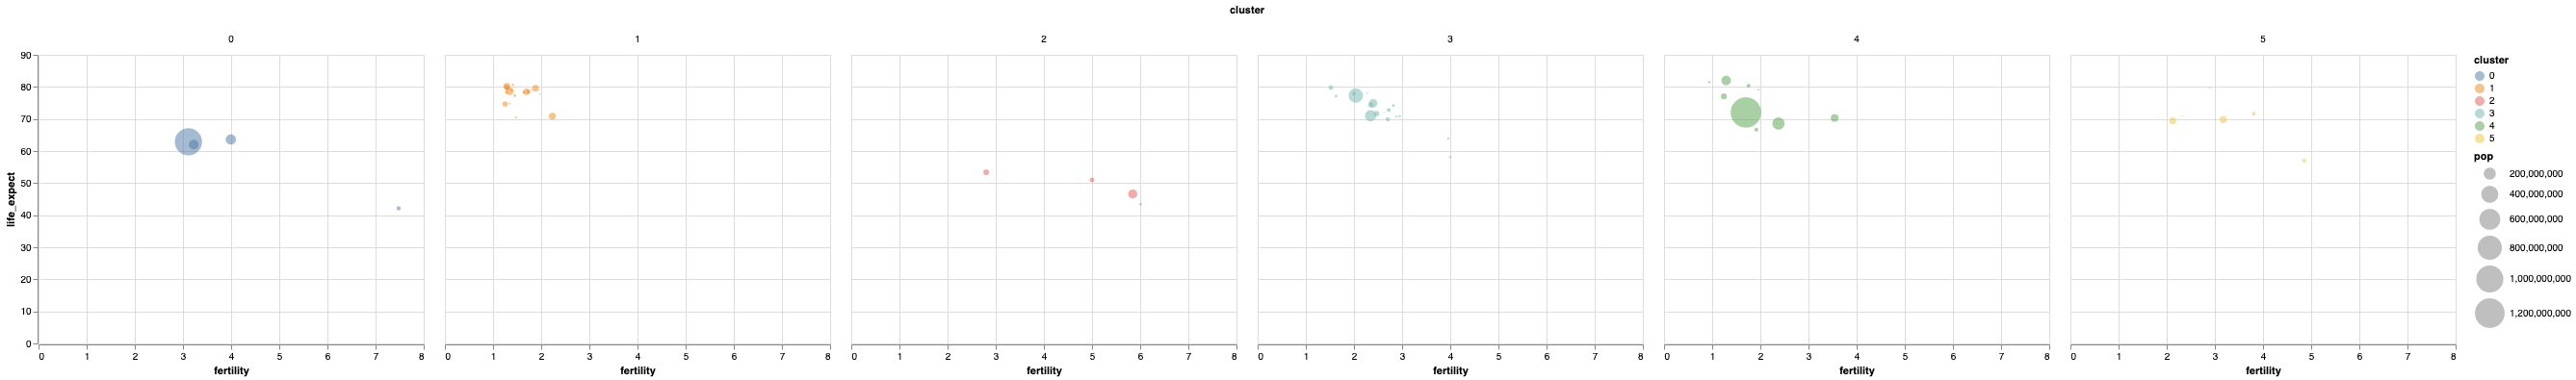

In [20]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000])),
    alt.Color('cluster:N'),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending'),
    alt.Column('cluster:N')
)

The plot above does not fit on screen, making it difficult to compare all the sub-plots to each other! We can set the default `width` and `height` properties to create a smaller set of multiples. Also, as the column headers already label the `cluster` values, let's remove our `color` legend by setting it to `None`. To make better use of space we can also orient our `size` legend to the `'bottom'` of the chart.

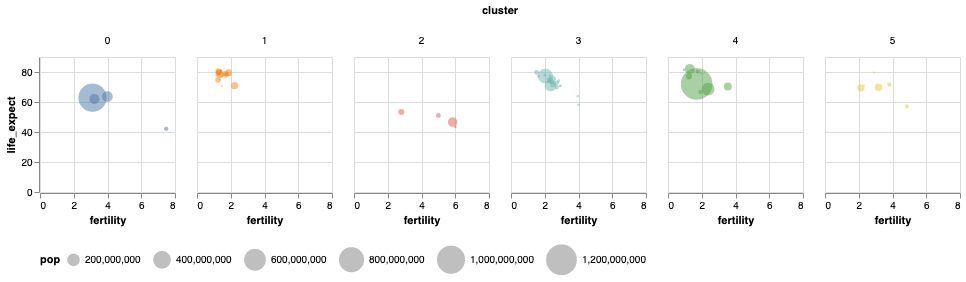

In [21]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000]),
             legend=alt.Legend(orient='bottom', titleOrient='left')),
    alt.Color('cluster:N', legend=None),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending'),
    alt.Column('cluster:N')
).properties(width=135, height=135)

Underneath the hood, the `column` and `row` encodings are translated into a new specification that uses the `facet` view composition operator. We will re-visit faceting in greater depth later on!

In the meantime, _can you rewrite the chart above to facet into rows instead of columns?_

### A Peek Ahead: Interactive Filtering

In later modules, we'll dive into interaction techniques for data exploration. Here is a sneak peak: binding a range slider to the `year` field to enable interactive scrubbing through each year of data. Don't worry if the code below is a bit confusing at this point, as we will cover interaction in detail later.

_Drag the slider back and forth to see how the data values change over time!_

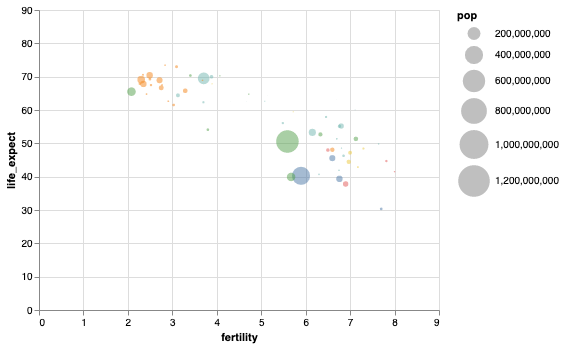

In [22]:
select_year = alt.selection_single(
    name='select', fields=['year'], init={'year': 1955},
    bind=alt.binding_range(min=1955, max=2005, step=5)
)

alt.Chart(data).mark_point(filled=True).encode(
    alt.X('fertility:Q', scale=alt.Scale(domain=[0,9])),
    alt.Y('life_expect:Q', scale=alt.Scale(domain=[0,90])),
    alt.Size('pop:Q', scale=alt.Scale(domain=[0, 1200000000], range=[0,1000])),
    alt.Color('cluster:N', legend=None),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending')
).add_selection(select_year).transform_filter(select_year)

## Graphical Marks

Our exploration of encoding channels above exclusively uses `point` marks to visualize the data. However, the `point` mark type is only one of the many geometric shapes that can be used to visually represent data. Altair includes a number of built-in mark types, including:

- `mark_area()` - Filled areas defined by a top-line and a baseline.
- `mark_bar()` -	Rectangular bars.
- `mark_circle()`	- Scatter plot points as filled circles.
- `mark_line()` - Connected line segments.
- `mark_point()` - Scatter plot points with configurable shapes.
- `mark_rect()` - Filled rectangles, useful for heatmaps.
- `mark_rule()` - Vertical or horizontal lines spanning the axis.
- `mark_square()` - Scatter plot points as filled squares.
- `mark_text()` - Scatter plot points represented by text.
- `mark_tick()` - Vertical or horizontal tick marks.	

For a complete list, and links to examples, see the [Altair marks documentation](https://altair-viz.github.io/user_guide/marks.html). Next, we will step through a number of the most commonly used mark types for statistical graphics.

### Point Marks

The `point` mark type conveys specific points, as in *scatter plots* and *dot plots*. In addition to `x` and `y` encoding channels (to specify 2D point positions), point marks can use `color`, `size`, and `shape` encodings to convey additional data fields.

Below is a dot plot of `fertility`, with the `cluster` field redundantly encoded using both the `y` and `shape` channels. 



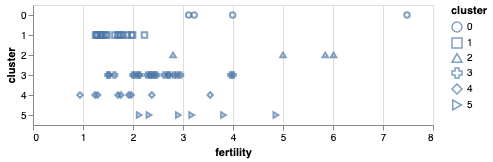

In [23]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:N'),
    alt.Shape('cluster:N')
)

In addition to encoding channels, marks can be stylized by providing values to the `mark_*()` methods.

For example: point marks are drawn with stroked outlines by default, but can be specified to use `filled` shapes instead. Similarly, you can set a default `size` to set the total pixel area of the point mark.


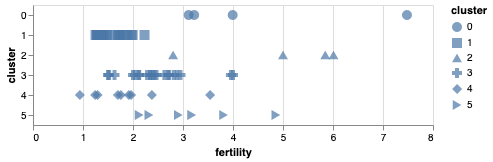

In [24]:
alt.Chart(data2000).mark_point(filled=True, size=100).encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:N'),
    alt.Shape('cluster:N')
)

### Circle Marks

The `circle` mark type is a convenient shorthand for `point` marks drawn as filled circles.

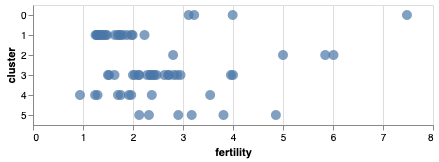

In [25]:
alt.Chart(data2000).mark_circle(size=100).encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:N'),
    alt.Shape('cluster:N')
)

### Square Marks

The `square` mark type is a convenient shorthand for `point` marks drawn as filled squares.

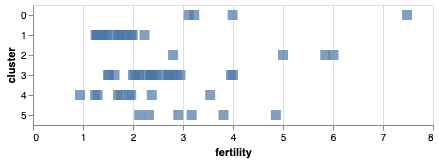

In [26]:
alt.Chart(data2000).mark_square(size=100).encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:N'),
    alt.Shape('cluster:N')
)

### Tick Marks

The `tick` mark type conveys a data point using a short line segment or "tick". These are particularly useful for comparing values along a single dimension with minimal overlap. A *dot plot* drawn with tick marks is sometimes referred to as a *strip plot*.

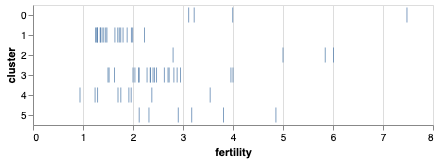

In [27]:
alt.Chart(data2000).mark_tick().encode(
    alt.X('fertility:Q'),
    alt.Y('cluster:N'),
    alt.Shape('cluster:N')
)

### Bar Marks

The \`bar\` mark type draws a rectangle with a position, width, and height.

The plot below is a simple bar chart of the population (\`pop\`) of each country.

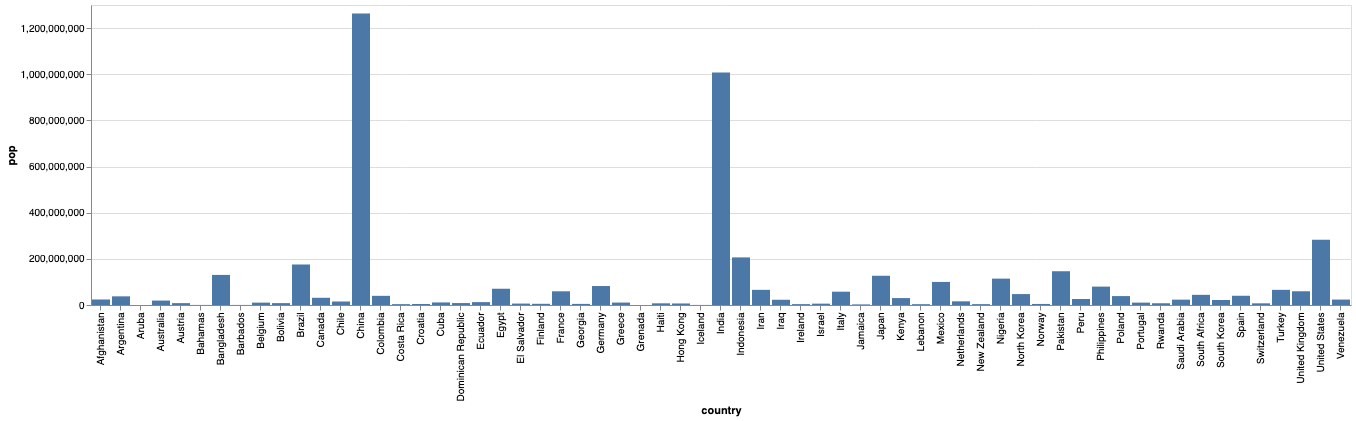

In [28]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('country:N'),
    alt.Y('pop:Q')
)

The bar width is set to a default size. To change the width, _try setting the \`rangeStep\` property of the \`x\` channel's \`scale\` attribute_. (In a later module we will take a closer look at configuring axes, scales, and legends.)

Bars can also be stacked. Let's change the `x` encoding to use the `cluster` field, and encode `country` using the `color` channel. We'll also disable the legend (which would be very long with colors for all countries!) and use tooltips for the country name.

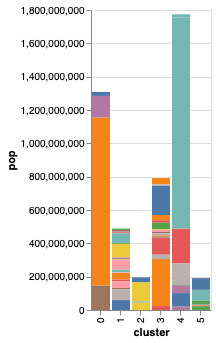

In [29]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('cluster:N'),
    alt.Y('pop:Q'),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
)

In the chart above, the use of the `color` encoding channel causes Altair / Vega-Lite to automatically stack the bar marks. Otherwise, bars would be drawn on top of each other! Try adding the parameter `stack=None` to the `y` encoding channel to see what happens if we don't apply stacking...

The examples above create bar charts from a zero-baseline, and the `y` channel only encodes the non-zero value (or height) of the bar. However, the bar mark also allows you to specify starting and ending points to convey ranges.

The chart below uses the `x` (starting point) and `x2` (ending point) channels to show the range of life expectancies within each regional cluster. Below we use the `min` and `max` aggregation functions to determine the end points of the range; we will discuss aggregation in greater detail in the next notebook!

Alternatively, you can use `x` and `width` to provide a starting point plus offset, such that `x2 = x + width`.

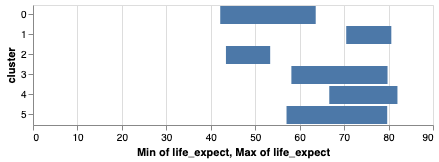

In [30]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('min(life_expect):Q'),
    alt.X2('max(life_expect):Q'),
    alt.Y('cluster:N')
)

### Line Marks

The `line` mark type connects plotted points with line segments, for example so that a line's slope conveys information about the rate of change.

Let's plot a line chart of fertility per country over the years, using the full, unfiltered global development data frame. We'll again hide the legend and use tooltips instead.


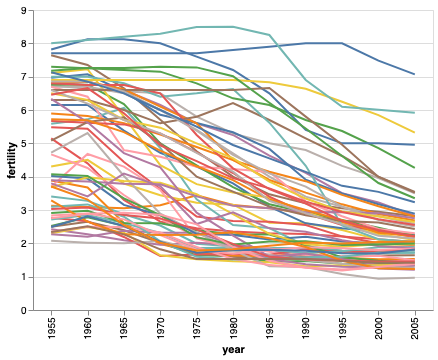

In [31]:
alt.Chart(data).mark_line().encode(
    alt.X('year:O'),
    alt.Y('fertility:Q'),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
).properties(
    width=400
)

We can see interesting variations per country, but overall trends for lower numbers of children per family over time. Also note that we set a custom width of 400 pixels. _Try changing (or removing) the widths and see what happens!_

Let's change some of the default mark parameters to customize the plot. We can set the `strokeWidth` to determine the thickness of the lines and the `opacity` to add some transparency. By default, the `line` mark uses straight line segments to connect data points. In some cases we might want to smooth the lines. We can adjust the interpolation used to connect data points by setting the `interpolate` mark parameter. Let's use `'monotone'` interpolation to provide smooth lines that are also guaranteed not to inadvertently generate "false" minimum or maximum values as a result of the interpolation.

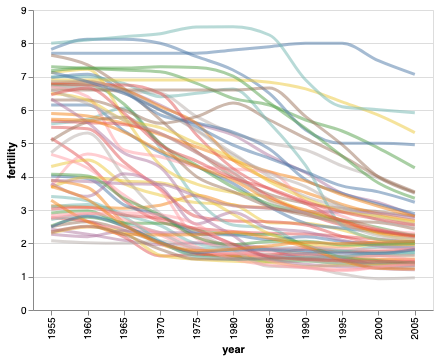

In [32]:
alt.Chart(data).mark_line(
    strokeWidth=3,
    opacity=0.5,
    interpolate='monotone'
).encode(
    alt.X('year:O'),
    alt.Y('fertility:Q'),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
).properties(
    width=400
)

The `line` mark can also be used to create *slope graphs*, charts that highlight the change in value between two comparison points using line slopes.

Below let's create a slope graph comparing the populations of each country at minimum and maximum years in our full dataset: 1955 and 2005. We first create a new Pandas data frame filtered to those years, then use Altair to create the slope graph.

By default, Altair places the years close together. To better space out the years along the x-axis, we can use the `scale` parameter's `rangeStep` property to indicate the size (in pixels) of discrete steps along the x-axis range. Try adjusting the `rangeStep` below and see how the chart changes in response.

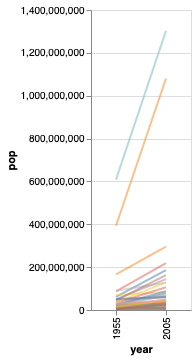

In [33]:
dataTime = data.loc[(data['year'] == 1955) | (data['year'] == 2005)]

alt.Chart(dataTime).mark_line(opacity=0.5).encode(
    alt.X('year:O', scale=alt.Scale(rangeStep=50)),
    alt.Y('pop:Q'),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
)

### Area Marks

The `area` mark type combines aspects of `line` and `bar` marks: it visualizes connections (slopes) among data points, but also shows a filled region, with one edge defaulting to a zero-valued baseline.

The chart below is an area chart of population over time for just the United States:

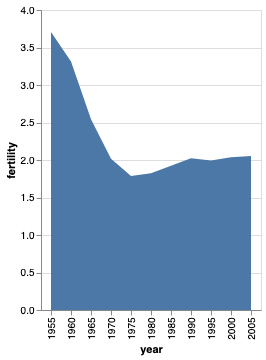

In [34]:
dataUS = data.loc[data['country'] == 'United States']

alt.Chart(dataUS).mark_area().encode(
    alt.X('year:O'),
    alt.Y('fertility:Q')
)

Similar to `line` marks, `area` marks support an `interpolate` parameter.

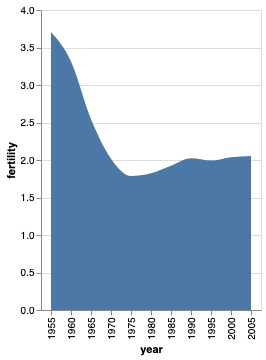

In [35]:
alt.Chart(dataUS).mark_area(interpolate='monotone').encode(
    alt.X('year:O'),
    alt.Y('fertility:Q')
)

Similar to `bar` marks, `area` marks also support stacking. Here we create a new data frame with data for the three North American countries, then plot them using an `area` mark and a `color` encoding channel to stack by country.

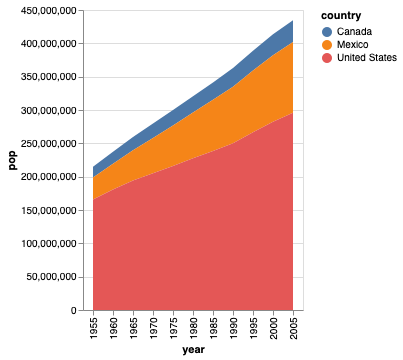

In [36]:
dataNA = data.loc[
    (data['country'] == 'United States') |
    (data['country'] == 'Canada') |
    (data['country'] == 'Mexico')
]

alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O'),
    alt.Y('pop:Q'),
    alt.Color('country:N')
)

By default, stacking is performed relative to a zero baseline. However, other `stack` options are available:

* `center` - to stack relative to a baseline in the center of the chart, creating a *streamgraph* visualization, and
* `normalize` - to normalize the summed data at each stacking point to 100%, enabling percentage comparisons.

Below we adapt the chart by setting the `y` encoding `stack` attribute to `center`. What happens if you instead set it `normalize`?

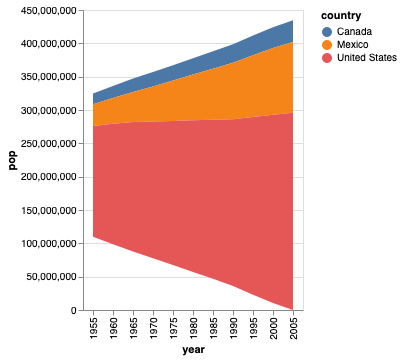

In [37]:
alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O'),
    alt.Y('pop:Q', stack='center'),
    alt.Color('country:N')
)

To disable stacking altogether, set the  `stack` attribute to `None`. We can also add `opacity` as a default mark parameter to ensure we see the overlapping areas!

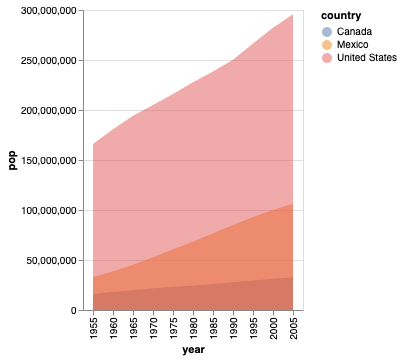

In [38]:
alt.Chart(dataNA).mark_area(opacity=0.5).encode(
    alt.X('year:O'),
    alt.Y('pop:Q', stack=None),
    alt.Color('country:N')
)

The `area` mark type also supports data-driven baselines, with both the upper and lower series determined by data fields. As with `bar` marks, we can use the `x` and `x2` (or `y` and `y2`) channels to provide end points for the area mark.

The chart below visualizes the range of minimum and maximum fertility, per year, for North American countries:

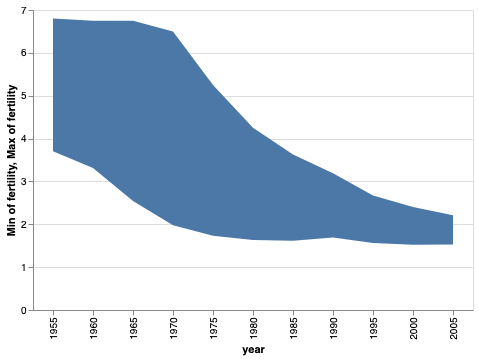

In [39]:
alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O', scale=alt.Scale(rangeStep=40)),
    alt.Y('min(fertility):Q'),
    alt.Y2('max(fertility):Q')
)

We can see a larger range of values in 1995, from just under 4 to just under 7. By 2005, both the overall fertility values and the variability have declined, centered around 2 children per familty.

All the `area` mark examples above use a vertically oriented area. However, Altair and Vega-Lite support horizontal areas as well. Let's transpose the chart above, simply by swapping the `x` and `y` channels.

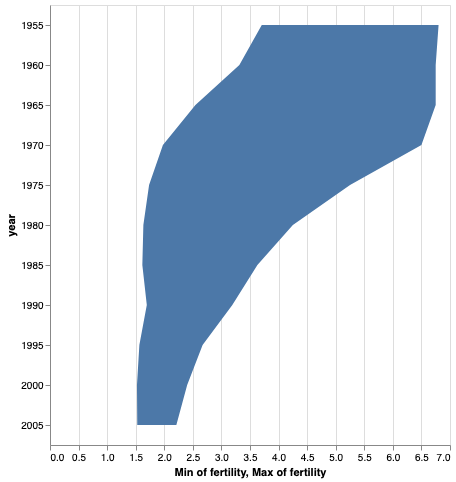

In [40]:
alt.Chart(dataNA).mark_area().encode(
    alt.Y('year:O', scale=alt.Scale(rangeStep=40)),
    alt.X('min(fertility):Q'),
    alt.X2('max(fertility):Q')
)

## Summary

We've completed our tour of data types, encoding channels, and graphical marks! You should now be well-equipped to further explore the space of encodings, mark types, and mark parameters. For a comprehensive reference &ndash; including features we've skipped over here! &ndash; see the Altair [marks](https://altair-viz.github.io/user_guide/marks.html) and [encoding](https://altair-viz.github.io/user_guide/encoding.html) documentation.

In the next module, we will look at the use of data transformations to create charts that summarize data or visualize new derived fields. In a later module, we'll examine how to further customize your charts by modifying scales, axes, and legends.

Interested in learning more about visual encoding?

<img title="Bertin's Taxonomy of Visual Encoding Channels" src="https://cdn-images-1.medium.com/max/2000/1*jsb78Rr2cDy6zrE7j2IKig.png" style="max-width: 650px;"><br/>

<small>Bertin's taxonomy of visual encodings from <a href="https://books.google.com/books/about/Semiology_of_Graphics.html?id=X5caQwAACAAJ"><em>Sémiologie Graphique</em></a>, as adapted by <a href="https://bost.ocks.org/mike/">Mike Bostock</a>.</small>

- The systematic study of marks, visual encodings, and backing data types was initiated by [Jacques Bertin](https://en.wikipedia.org/wiki/Jacques_Bertin) in his pioneering 1967 work [_Sémiologie Graphique (The Semiology of Graphics)_](https://books.google.com/books/about/Semiology_of_Graphics.html?id=X5caQwAACAAJ). The image above illustrates position, size, value (brightness), texture, color (hue), orientation, and shape channels, alongside Bertin's recommendations for the data types they support.
- The framework of data types, marks, and channels also guides _automated_ visualization design tools, starting with [Mackinlay's APT (A Presentation Tool)](https://scholar.google.com/scholar?cluster=10191273548472217907) in 1986 and continuing in more recent systems such as [Voyager](http://idl.cs.washington.edu/papers/voyager/) and [Draco](http://idl.cs.washington.edu/papers/draco/).
- The identification of nominal, ordinal, interval, and ratio types dates at least as far back as S. S. Steven's 1947 article [_On the theory of scales of measurement_](https://scholar.google.com/scholar?cluster=14356809180080326415).